# Introduction

In [2]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import requests
from lxml import etree

In [3]:
%matplotlib inline

# Obtain the data

## Querying the Kalliope SRU API

As documented in the APIs [\[1\]](http://kalliope.staatsbibliothek-berlin.de/en/support/sru.html) and [[2]](http://kalliope.staatsbibliothek-berlin.de/en/support/cql.html), we use the `ead.archdesc.id` property ("all records of a finding aid with the record ID of the collection level record") as a query parameter, passing it the collection ID of the "Gelehrtenbriefe" as an argument.

Note that we already know how many results there are: it's 3116. In this way, we can preset the argument `maximumRecords` of SRU to be sure that we're dowloading the whole thing. It's not very robust but it works for the moment...

In [4]:
# the collection id of the Letters
coll_id = "DE-611-BF-65759"
max_record = 3500
u = "http://kalliope-verbund.info/sru?version=1.2&operation=searchRetrieve&query=ead.archdesc.id={}&maximumRecords={}&recordSchema=mods".format(
coll_id, max_record)

In [5]:
r = requests.get(u)

## Handling the xml response

### Downloading the records

In [6]:
ns = {"srw" : "http://www.loc.gov/zing/srw/",
     "mod" : "http://www.loc.gov/mods/v3"}

In [7]:
x = etree.fromstring(r.content)
records = x.xpath("//srw:records/srw:record", namespaces=ns)

In [8]:
# did we get the whole thing?
tot = int(x[1].text)
assert tot == len(records), "The total nr. of record is {}. You got {}".format(tot, len(records))

### Example: how is a record structured?

```xml
<srw:record>
  <srw:recordSchema>mods</srw:recordSchema>
  <srw:recordPacking>xml</srw:recordPacking>
  <srw:recordData>
    <mods version="3.4" xsi:schemaLocation="http://www.loc.gov/mods/v3 http://www.loc.gov/standards/mods/v3/mods-3-4.xsd">
      <identifier type="uri">http://kalliope-verbund.info/DE-611-HS-3333951</identifier>
      <recordInfo>
        <recordIdentifier source="DE-611">DE-611-HS-3333951</recordIdentifier>
        <recordCreationDate encoding="marc">20171130</recordCreationDate>
        <recordChangeDate encoding="iso8601">20171130</recordChangeDate>
        <recordContentSource authority="marcorg">Deutsches Arch&#xE4;ologisches Institut. Abteilung Rom. Archiv</recordContentSource>
        <languageOfCataloging>
          <languageTerm authority="iso639-2b">mis</languageTerm>
          <languageTerm type="text">Einzelne andere Sprachen</languageTerm>
        </languageOfCataloging>
      </recordInfo>
      <relatedItem>
        <identifier type="localparentid">DE-611-BF-70019</identifier>
        <identifier type="uri">http://kalliope-verbund.info/DE-611-BF-70019</identifier>
        <titleInfo>
          <title>Gelehrtenbriefe - Gelehrtenbriefe von Bunsen, Christian Karl Josias von</title>
        </titleInfo>
      </relatedItem>
      <typeOfResource manuscript="yes">text</typeOfResource>
      <name type="personal" authority="GND" valueURI="http://d-nb.info/gnd/118668005">
        <namePart>Bunsen, Christian Karl Josias von (1791-1860)</namePart>
        <role>
          <roleTerm type="code" authority="marcrelator">aut</roleTerm>
          <roleTerm>author</roleTerm>
        </role>
      </name>
      <name type="personal" authority="GND" valueURI="http://d-nb.info/gnd/116023260">
        <namePart>Panofka, Theodor Sigismund (1800-1858)</namePart>
        <role>
          <roleTerm type="code" authority="marcrelator">rcp</roleTerm>
          <roleTerm>addressee</roleTerm>
        </role>
      </name>
      <titleInfo>
        <title>Brief von Christian Karl Josias von Bunsen an Theodor Sigismund Panofka</title>
      </titleInfo>
      <originInfo>
        <dateCreated encoding="w3cdtf">1833-07-15</dateCreated>
        <place>
          <placeTerm type="text">Frascati</placeTerm>
        </place>
      </originInfo>
      <language>
        <languageTerm authority="iso639-2b">ger</languageTerm>
        <languageTerm type="text">Deutsch</languageTerm>
      </language>
      <location>
        <shelfLocator>D-DAI-ROM-A-A-II-BunC-PanT-003</shelfLocator>
      </location>
      <location>
        <url note="Digitalisat">http://arachne.uni-koeln.de/books/archive/A-II-BunC-PanT-003</url>
      </location>
      <physicalDescription>
        <extent>2 Seiten.</extent>
      </physicalDescription>
    </mods>
  </srw:recordData>
</srw:record>
```

### How to build a network

Now is the moment to make several choices. As it can be seen, the Kalliope DM structures the data so that:
* the letter is the basic record
* the letter has a few properties (nr. of pages, place, data, actors involved with roles, language...)
* the persons are linked within a letter

How do we proceed from here? In particular, there are a few decisions that must be made:
1. a simple or a bipartite network?
2. what to do of date and space?

A bipartite network is one that involves two types of nodes: letters and persons; a simple network is one that only involves persons. Bipartite graphs can always be projected on simple graphs, so this is probably the safest choice. In the first exploration, let us just go with simple graphs. We ignore space and time for the present.

I am also working only with letters that have an "author" and an "addressee" as roles; some letters where either only one actor is involved or where both actors are involved with the role of "org", so that there is no clear direction in the correpsondence, were skipped (e.g. [here](http://kalliope-verbund.info/DE-611-BF-70161), or [here](http://kalliope-verbund.info/en/ead?ead.id=DE-611-BF-70163)).

In the end I keep 3077 out of the original 3116.

In [9]:
nodes = [] # a list of tuples: id,name
edges = []
for r in records:
    names = r.xpath("descendant::mod:name", namespaces=ns)
    d = {}

    for n in names:
        name = n[0].text
        role = n[1][0].text
        d[role] = name
    if "org" in list(d.keys()):
        continue
    else:
        edges.append((d["aut"], d["rcp"]))

In [10]:
len(edges)

3109

Now we turn this edge list into a counter, so that we have a weight metric.

In [11]:
from collections import Counter
c = Counter(edges)

In [12]:
edge_list = [(k[0], k[1], v) for k,v in c.items()]

In [13]:
edge_list[0]

('Abeken, Heinrich (1809-1872)', 'Braun, Emil (1809-1856)', 2)

In [14]:
edge_list

[('Abeken, Heinrich (1809-1872)', 'Braun, Emil (1809-1856)', 2),
 ('Abeken, Heinrich (1809-1872)', 'Henzen, Wilhelm (1816-1887)', 1),
 ('Abeken, Heinrich (1809-1872)', 'Abeken, Wilhelm (1813-1843)', 2),
 ('Abeken, Heinrich (1809-1872)', 'Unbekannt', 3),
 ('Abeken, Heinrich (1809-1872)',
  'Istituto di Corrispondenza Archeologica',
  1),
 ('Abeken, Heinrich (1809-1872)', 'Kestner, August (1777-1853)', 1),
 ('Abeken, Heinrich (1809-1872)', 'Lepsius, Carl Richard (1810-1884)', 1),
 ('Acerbi, Giuseppe (1773-1846)', 'Unbekannt', 1),
 ('Acerbi, Giuseppe (1773-1846)',
  'Bunsen, Christian Karl Josias von (1791-1860)',
  2),
 ('Acerbi, Giuseppe (1773-1846)', 'Bunsen, Carl von (1821-1887)', 1),
 ('Abeken, Wilhelm (1813-1843)', 'Braun, Emil (1809-1856)', 44),
 ('Abeken, Wilhelm (1813-1843)', 'Braun, Louise', 1),
 ('Abeken, Wilhelm (1813-1843)', 'Gerhard, Eduard (1795-1867)', 15),
 ('Abeken, Wilhelm (1813-1843)', 'Mai, Angelo (1782-1854)', 1),
 ('Abeken, Wilhelm (1813-1843)', 'Tessieri, Pietro (1

### Build the (directed) graph

In [18]:
G = nx.DiGraph()

In [19]:
G.add_weighted_edges_from(edge_list)

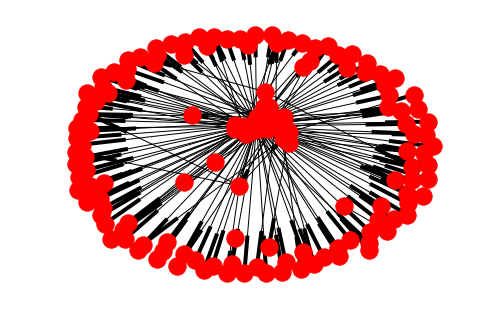

In [20]:
nx.draw_spring(G)

In [21]:
nx.write_gexf(G, "/Users/fmambrini/Desktop/Gelehrtenkorr.gexf")

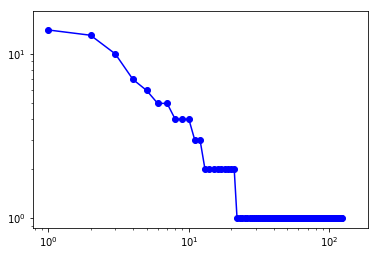

<Container object of 12 artists>

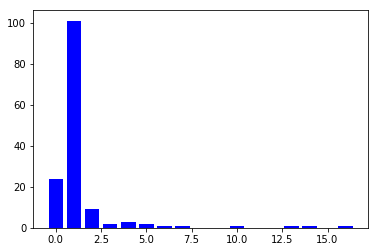

In [102]:
degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)
plt.loglog(degree_sequence, 'b-', marker='o')
plt.show()

degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

---

In [42]:
names = r.xpath("descendant::mod:name", namespaces=ns)

In [50]:
n = names[0]

In [54]:
n[0].text

'Bunsen, Christian Karl Josias von (1791-1860)'

In [20]:
len(records)

3116

In [11]:
x.tag

'{http://www.loc.gov/zing/srw/}searchRetrieveResponse'

In [32]:
r = records[12]

In [39]:
r[2][0][5]

<Element {http://www.loc.gov/mods/v3}name at 0x117bfd708>

In [ ]:
nx.draw()

# Creating a GDF file for dynamic networks

On the GDF format see [here](http://graphexploration.cond.org/manual.html#_Toc116465166)

In [86]:
nodes = [] # a list of tuples: id,name
edges = []
for r in records:
    names = r.xpath("descendant::mod:name", namespaces=ns)
    d = {}
    try:
        letter_date = r.xpath("descendant::mod:originInfo/mod:dateCreated", namespaces=ns)[0].text
        year = letter_date.split("-")[0]
    except IndexError:
        year = 'unknown'
        letter_date = 'unknown'
    try:
        letter_place = r.xpath("descendant::mod:originInfo/mod:place/mod:placeTerm", namespaces=ns)[0].text
    except IndexError:
        letter_place = "ohne Ort"

    for n in names:
        name = n[0].text
        try:
            gnd = n.attrib["valueURI"].split("/")[-1]
        except KeyError:
            gnd = name.replace(" ", "")
        role = n[1][0].text
        d[role] = (gnd,name)
        nodes.append((gnd,name))
    if "org" in list(d.keys()):
        continue
    else:
        edges.append((d["aut"][0], d["rcp"][0], letter_place, year, letter_date))

In [87]:
for n in set(edges):print(n)

('119429713', '118710605', 'Rom', '1852', '1852-12-11')
('118717030', '118710605', 'Berlin', '1859', '1859-07-27')
('118717030', '116415738', 'Berlin', '1842', '1842')
('118717030', '118710605', 'Berlin', '1865', '1865-12-23')
('118717030', '116415738', 'Berlin', '1841', '1841-06-06')
('118717030', '116415738', 'Berlin', '1838', '1838-02-27')
('116777273', '118710605', 'Volterra', '1863', '1863-09-09')
('116288272', '116415738', 'Neapel', '1843', '1843-12-17')
('116006498', '116415738', 'Rom', '1844', '1844-05-15')
('116001291', '116415738', 'Rom', '1839', '1839-08-17')
('118717030', '118710605', 'Berlin', '1859', '1859-01-06')
('116415738', '118717030', 'Gotha', '1849', '1849-11-14')
('118717030', '118710605', 'Berlin', '1866', '1866-11-12')
('116001127', '118727699', 'Ohne Ort', '1837', '1837-07-24')
('119291622', '118710605', 'Civitavecchia', '1863', '1863-03-21')
('116415738', '117420557', 'Rom', '1835', '1835-01-02')
('116777273', '118710605', 'München', '1877', '1877-11-09')
('11

('118717030', '116023260', 'Rom', '1834', '1834-02-06')
('116415738', '118717030', 'Rom', '1852', '1852-12-15')
('118717030', '116415738', 'Livorno', '1837', '1837-06-26')
('116777273', '118717030', 'Rom', '1857', '1857-12-11')
('118717030', '116415738', 'Berlin', '1838', '1838-05-13')
('118717030', '116415738', 'Berlin', '1846', '1846-06-11')
('119429713', '116415738', 'Rom', '1841', '1841-07-14')
('1041847998', '35363-2', 'Catania', '1835', '1835-12-24')
('116415738', '118717030', 'Gotha', '1839', '1839-08-30')
('116777273', '118710605', 'Florenz', '1864', '1864-10-20')
('118717030', '118710605', 'Berlin', '1853', '1853-03-14')
('116895403', '116415738', 'Ohne Ort', '1843', '1843-02-11')
('118668005', '116125888', 'Ohne Ort', 'o.D.', 'o.D.')
('116415738', '118717030', 'Rom', '1844', '1844-06-08')
('116415738', '118717030', 'Rom', '1835', '1835-01-06')
('118717030', '116415738', 'Berlin', '1837', '1837-12-07')
('118717030', '118710036', 'Wernigerode', '1866', '1866-08-22')
('118717030

('116415738', '118717030', 'Rom', '1855', '1855-03-02')
('118717030', '116415738', 'Berlin', '1835', '1835-01-06')
('116777273', '118717030', 'Rom', '1862', '1862-07-01')
('118668005', '116415738', 'Ohne Ort', '1836', '1836-11-06')
('118717030', '116415738', 'Berlin', '1844', '1844-02-08')
('118717030', '116415738', 'Berlin', '1848', '1848-10-12')
('116001291', '116415738', 'Rom', '1839', '1839-09-07')
('116415738', '118717030', 'Rom', '1847', '1847-02-20')
('118717030', '118710605', 'Berlin', '1849', '1849-01-09')
('119291622', '116415738', 'Civitavecchia', '1834', '1834-09-05')
('116415738', '118717030', 'Rom', '1841', '1841-06-18')
('116415738', '118717030', 'Rom', '1844', '1844-11-23')
('116777273', '118710605', 'München', '1865', '1865-06-22')
('116001291', '116415738', 'Frascati', '1838', '1838-07-25')
('118717030', '118710605', 'Berlin', '1866', '1866-05-06')
('118717030', '116125888', 'Berlin', '1833', '1833-03-26')
('118717030', '118710605', 'Berlin', '1857', '1857-01-31')
('1

In [119]:
grouped_edges = [("{}#-#{}".format(e[0],e[1]), e[-1]) for e in edges]

Using `defaultdict` we can easily group the date values, using the code exemplified [here](https://docs.python.org/3/library/collections.html#collections.defaultdict)

In [133]:
from collections import defaultdict
d = defaultdict(list)
for k,v in grouped_edges:
    d[k].append(v)

Now we append the original weight of the edge, by simply counting the number of dates (including "unknown" or "o.D")

In [135]:
for k,v in d.items():
    d[k] = (v, len(v))

In [123]:
d["1041847998#-#116415738"]

(['1836-06-05', '1836-06-18'], 2)

We remove the missing dates from the date list (we preserve the information on the total number of letters in the weight)

In [137]:
for k,v in d.items():
    dates,weight = v
    d[k] = ( [date for date in dates if re.search("^\d{4}", date)], weight)

Now let us write the whole thing down to a gdf file

In [114]:
nodes[0]

('1148171118', 'Deutsches Archäologisches Institut. Abteilung Rom. Archiv')

In [148]:
with open("/Users/fmambrini/Desktop/KorrNetworkComplete.gdf", "w") as out:
    out.write("nodedef>name VARCHAR,label VARCHAR\n")
    for n in set(nodes):
        out.write('"{}","{}"\n'.format(n[0],n[1]))
    out.write("edgedef>node1 VARCHAR,node2 VARCHAR,directed,start VARCHAR, weight DOUBLE\n")
    for k,v in d.items():
        source,target = k.split("#-#")
        ordered_dates = sorted([ date for date in v[0] ])
        try:
            start = ordered_dates[0]
        except IndexError:
            start = ''
        s = '"{}","{}",true,{},{}\n'.format(source,target,start,v[-1])
        out.write(s)

In [146]:
v

(['1878-07-28', '1878-07-02', '1880-01-29', '1880-02-23', '1880-10-29'], 6)

In [43]:
#<originInfo><dateCreated>
r.xpath("descendant::mod:originInfo/mod:dateCreated", namespaces=ns)[0].text

'1829/1899'

In [42]:
r.xpath("descendant::mod:place", namespaces=ns)

[]

In [46]:
names

[<Element {http://www.loc.gov/mods/v3}name at 0x1120e4d88>]

In [70]:
from dateutil.parser import parse

In [77]:
dates = [parse("1842-09-06"), parse("1842-12-25"), parse("1834-02-28")]
sorted(dates)

[datetime.datetime(1834, 2, 28, 0, 0),
 datetime.datetime(1842, 9, 6, 0, 0),
 datetime.datetime(1842, 12, 25, 0, 0)]

-4017862800.0